## Import libs and custom vars

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from libs.utils import find_penalty, return_outcome, check_element, add_labels
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
import datetime
from numba import jit

<ul>
    <li>Ci sono alcuni nomi di squadre che sono cambiate nel tempo, uniformizza </li>
    <li>Shootouts è il db dei penalty, quindi bisogna manipolare il dataset per vedere chi vince alla fine quella partita</li>
</ul>

## Descrizione del dataset e preprocessing

Il Dataset contiene 42483 risultati di partite di calcio internazionale,

Il primo match risale al 1872-11-30 mentre l’ultimo è del 2021-08-01

Nel dataset sono incluse sia le partite ufficiali di tutte le competizioni, dalle amichevoli alla coppa del mondo. è da specificare inoltre che comprende solo le competizioni nazionali maschili e sono esclusi: Olympic Games or matches where at least one of the teams was the nation's B-team, U-23 or a league select team.

Inoltre, il dataset presenta un ulteriore file che contiene, in totale 432 risultati finali di partite terminate ai calci di rigore (vincenti).

Per correttezza, controlleremo inizialmente che il Dataset non contenga elementi nulli e i due dataset verranno inoltre ‘mergiate’ in un unico file contenti i risultati, dove presenti, anche dopo i calci di rigore.

In [7]:
data = {
    'results': pd.read_csv('dataset/results.csv'),
    'shootouts': pd.read_csv('dataset/shootouts.csv')
}

# print('**'*5, ' results.csv ', '**'*5)
# print(data['results'].info())
# print('**'*5, ' shootouts.csv ', '**'*5)
# print(data['shootouts'].info())

Il dataset non contiene elementi nulli. Visualizziamo le prime 5 righe di ogni dataset

In [ ]:
print('**'*5, ' results.csv ', '**'*5)
print(data['results'].head(5))
print('**'*5, ' shootouts.csv ', '**'*5)
print(data['shootouts'].head(5))

Applichiamo dunque alcune modifiche al dataset. Si integrano di conseguenza alcune informazioni del dataset 'shootouts'

In particolare, processeremo il dataset (partendo da quello di results.csv):
- aggiungendo la colonna 'outcome', sarà classificato come:
    - H (home win)
    - A (away win)
    - D (draw), in particolare se in 'shootouts' è presente la partita 'draw':
        - HP (home win at penalty)
        - AP (away win at penalty)

- saranno estratti i dati relativi alla data della partita in quanto serviranno successivamente

In [8]:
dst_df = data['results'].copy()

res_len = data['results'].__len__()
sht_len = data['shootouts'].__len__()

print('results.csv tot records: %d | shape: %s' % (res_len, data['results'].shape))
print('shootouts.csv tot records: %d | shape: %s' % (sht_len, data['shootouts'].shape))

results.csv tot records: 42483 | shape: (42483, 9)
shootouts.csv tot records: 432 | shape: (432, 4)


In [ ]:
# aggiungo una colonna al dataFrame che aggiorna con i risultati dei rigori

dst_df['outcome'] = None
dst_df['day_of_week'] = None
dst_df['month'] = None
dst_df['year'] = None

counter = 0
for i in range(0, res_len):
    counter = counter + 1
    print('*** Processing %d/%d ***' % (counter, res_len), end='\r')

    # estraggo dati necessari dalla data
    row_date = datetime.date.fromisoformat(dst_df.iloc[i]['date'])

    dst_df.at[i, 'day_of_week'] = row_date.strftime('%A')
    dst_df.at[i, 'month'] = row_date.strftime('%B')
    dst_df.at[i, 'year'] = int(row_date.strftime('%Y'))

    # calcolo il risultato della partita
    dst_df.at[i, 'outcome'] = return_outcome(data['results'].iloc[i]['home_score'], data['results'].iloc[i]['away_score'])

    if(dst_df.iloc[i]['outcome'] == 'D'):
        dst_df.at[i, 'outcome'] = find_penalty(data['results'].iloc[i], data['shootouts'], sht_len - 1)

dst_df.to_csv('dataset/dataset.csv')
dst_df.head()

## Domande / risposte / prima analisi

- ~~Tipi di competizioni giocate maggiormente~~
- Le nazioni che hanno ospitato più coppe del mondo
- ~~Squadre che hanno giocato di più~~
- ~~Squadra che ha vinto di più~~
    - Giocare in casa è un vantaggio? --- PMF
    - Chi vince di più in casa vince ovunque?
    - Giocare di più è un vantaggio per vincere ?

<br><br>
- ~~Num Partite giocate per anno -> aumentati?~~
- Totale di partite giocate per decade
- Il giorno della settimana dove si gioca di più per decade

<br><br>
- Analisi goal/difesa per ogni anno/decade
- Media di goal per decade
- Numero di goal è diminuito nel tempo?
- BOXPLOT con goal segnati in a casa e fuori casa








- CASO ITALIANO

In [2]:
dst_df = pd.read_csv('dataset/dataset.csv')
# elimino le colonne non necessarie per lo studio attuale
dst_df.drop(labels=['Unnamed: 0', 'match_id', 'date'], inplace=True, axis=1)

dst_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42483 entries, 0 to 42482
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   home_team    42483 non-null  object
 1   away_team    42483 non-null  object
 2   home_score   42483 non-null  int64 
 3   away_score   42483 non-null  int64 
 4   tournament   42483 non-null  object
 5   city         42483 non-null  object
 6   country      42483 non-null  object
 7   neutral      42483 non-null  bool  
 8   outcome      42483 non-null  object
 9   day_of_week  42483 non-null  object
 10  month        42483 non-null  object
 11  year         42483 non-null  int64 
dtypes: bool(1), int64(3), object(8)
memory usage: 3.6+ MB


#### Tipi di competizioni giocate maggiormente.
In un primo output della tabella è evidente la presenza di competizioni con anche solo 1 partita giocate. Di conseguenza consideriamo solo le prime 20 competizioni giocate maggiormente, scartando le altre.

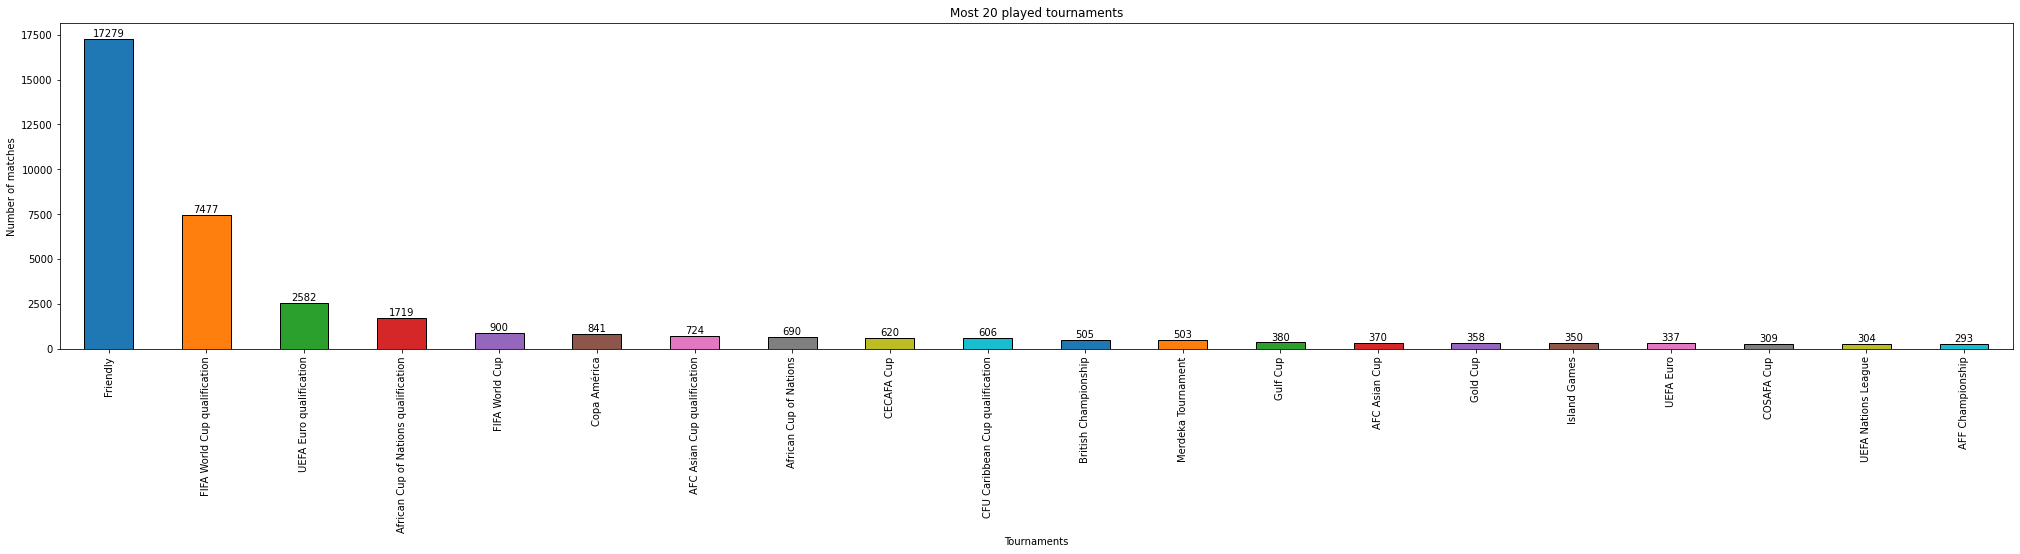

In [40]:
plot_graph = dst_df['tournament'].value_counts()[:20].plot(kind='bar', figsize=(35,6), title='Most 20 played tournaments', xlabel='Tournaments', ylabel='Number of matches', color=[i for i in mcolors.TABLEAU_COLORS], edgecolor='black')
plot_graph.bar_label(container=plot_graph.containers[0], label_type='edge')
plt.show()

#### Squadra che ha giocato di più

In [28]:
ht = dst_df['home_team'].value_counts().rename_axis('team').reset_index(name='home_team')
at = dst_df['away_team'].value_counts().rename_axis('team').reset_index(name='home_team')

print(ht.__len__() == at.__len__())

ht.columns = ['team', 'matches']
at.columns = ['team', 'matches']

# ht contiene più righe di away_team, significa che qualche squadra ha disputato solo partite a casa,
# NOTA: LE HO CALCOLATE DOPO. DEVI INSERIRE QUI QUALI SONO E FAI N POCO DI STORIA MAGARI STRONZ?

# home away team
hat = ht.copy()

# aggiungo altre due colonne per il conteggio dei matches
hat['away_matches'] = None
hat['tot'] = None

hat.columns = ['team', 'home_matches', 'away_matches', 'tot']

for i in range(0, ht.__len__()):
    for j in range(0, at.__len__() - 1):
        if(ht.iloc[i]['team'] == at.iloc[j]['team']):
            hat.at[i, 'away_matches'] = at.iloc[j]['matches']
            hat.at[i, 'tot'] = at.iloc[j]['matches'] + ht.iloc[i]['matches']

            break   # il valore è stato trovato quindi termino il loop

# teams only home match
teams_ohm = []

for i in range(0, hat.__len__()):
    if hat.iloc[i]['away_matches'] is None:
        print("La squadra che ha giocato in casa e non fuori casa è: " + hat.iloc[i]['team'])
        teams_ohm.append(hat.iloc[i]['team'])
        hat.at[i, 'away_matches'] = 0
        hat.at[i, 'tot'] = hat.iloc[i]['home_matches'] + hat.iloc[i]['away_matches']

# *****************************************+
hat.to_csv('dataset/most_games.csv')  # per semplicità, elimina poi
print(hat.info())
print(hat.head())

False
La squadra che ha giocato in casa e non fuori casa è: Silesia
La squadra che ha giocato in casa e non fuori casa è: Canary Islands
La squadra che ha giocato in casa e non fuori casa è: Republic of St. Pauli
La squadra che ha giocato in casa e non fuori casa è: Găgăuzia
La squadra che ha giocato in casa e non fuori casa è: Niue
La squadra che ha giocato in casa e non fuori casa è: Palau
La squadra che ha giocato in casa e non fuori casa è: Madrid
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 308 entries, 0 to 307
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   team          308 non-null    object
 1   home_matches  308 non-null    int64 
 2   away_matches  308 non-null    object
 3   tot           308 non-null    object
dtypes: int64(1), object(3)
memory usage: 9.8+ KB
None
        team  home_matches away_matches   tot
0     Brazil           581          418   999
1  Argentina           557          439  

In [33]:
teams_ohm[0]

'Silesia'

In [15]:
hat.sort_values(by=['tot'], ascending=False, inplace=True)
hat.reset_index(inplace=True)
hat.drop(columns=['index'], inplace=True)
hat.index = hat.index + 1
hat.head(10)

,team,home_matches,away_matches,tot
1,Sweden,497,539,1036
2,England,513,516,1029
3,Brazil,581,418,999
4,Argentina,557,439,996
5,Germany,518,449,967
6,Hungary,464,484,948
7,Uruguay,351,547,898
8,Mexico,524,364,888
9,South Korea,471,397,868
10,France,493,364,857


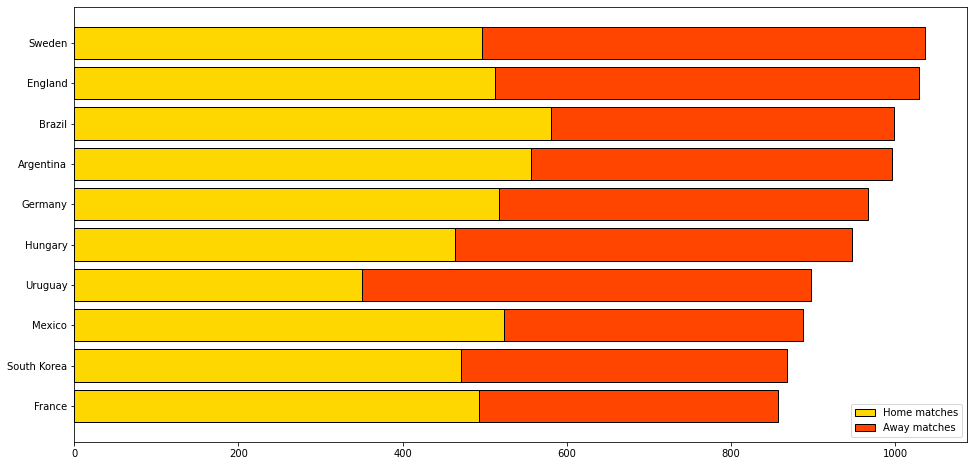

In [16]:
plt.figure(figsize=(16,8))
plt.barh(hat['team'][:10], hat['home_matches'][:10], color='gold', edgecolor='black')
plt.barh(hat['team'][:10], hat['away_matches'][:10], left=hat['home_matches'][:10] ,color='orangered', edgecolor='black')
plt.legend(['Home matches', 'Away matches'])

plt.gca().invert_yaxis()

plt.show()

controllo le squadre che hanno fatto solo partite in casa

In [45]:
matches_ohm = pd.DataFrame()

for i in range(0, dst_df.__len__()):
    for j in range(0, teams_ohm.__len__()):
        if(dst_df.iloc[i]['home_team'] == teams_ohm[j]):
            matches_ohm = matches_ohm.append(dst_df.iloc[i])

matches_ohm['home_score'] = matches_ohm['home_score'].astype(int)
matches_ohm['away_score'] = matches_ohm['away_score'].astype(int)
matches_ohm['neutral'] = matches_ohm['neutral'].astype(bool)
matches_ohm['year'] = matches_ohm['year'].astype(int)

matches_ohm.to_csv('dataset/only_home_matches.csv')

matches_ohm.head(5)

,home_team,away_team,home_score,away_score,tournament,city,country,neutral,outcome,day_of_week,month,year
1618,Silesia,Poland,1,2,Friendly,Katowice,Poland,False,A,Wednesday,October,1933
1993,Silesia,Basque Country,3,4,Friendly,Chorzów,Poland,False,A,Wednesday,June,1937
2834,Silesia,Czechoslovakia,2,1,Friendly,Chorzów,Poland,False,H,Tuesday,April,1948
3379,Silesia,China PR,5,1,Friendly,Chorzów,Poland,False,H,Sunday,August,1952
3487,Silesia,Poland,2,3,Friendly,Chorzów,Poland,False,A,Sunday,April,1953


#### Squadra che ha vinto di più in totale
- casa/fuori
- è più facile giocare in casa?

In [3]:
# win rate teams dataFrame
wrt_df = pd.read_csv('dataset/most_games.csv')

wrt_df.drop(labels=['Unnamed: 0'], inplace=True, axis=1)
wrt_df.sort_values(by=['team'], ascending=False)

wrt_df['home_win'] = 0
wrt_df['away_win'] = 0

wrt_df['home_draw'] = 0
wrt_df['away_draw'] = 0

wrt_df['home_loss'] = 0
wrt_df['away_loss'] = 0

# penalty
wrt_df['home_win_penalty'] = 0
wrt_df['home_loss_penalty'] = 0

wrt_df['away_win_penalty'] = 0
wrt_df['away_loss_penalty'] = 0

# aggiungere partite giocate in campo neutrale?

for i in range(0, wrt_df.__len__()):
    # per ogni partita
    for j in range(0, dst_df.__len__()):
        # se la squadra del dst win rate:
        # è in casa
        if (wrt_df.iloc[i]['team'] == dst_df.iloc[j]['home_team']):

            if (dst_df.iloc[j]['outcome'] == 'H'):
                wrt_df.at[i, 'home_win'] = wrt_df.iloc[i]['home_win'] + 1

            if (dst_df.iloc[j]['outcome'] == 'D'):
                wrt_df.at[i, 'home_draw'] = wrt_df.iloc[i]['home_draw'] + 1

            if (dst_df.iloc[j]['outcome'] == 'A'):
                wrt_df.at[i, 'home_loss'] = wrt_df.iloc[i]['home_loss'] + 1

            if (dst_df.iloc[j]['outcome'] == 'HP'):
                wrt_df.at[i, 'home_win_penalty'] = wrt_df.iloc[i]['home_win_penalty'] + 1
            
            if (dst_df.iloc[j]['outcome'] == 'AP'):
                wrt_df.at[i, 'home_loss_penalty'] = wrt_df.iloc[i]['home_loss_penalty'] + 1

        # è fuori casa...
        if (wrt_df.iloc[i]['team'] == dst_df.iloc[j]['away_team']):
            # e ha vinto la squadr adi casa..
            if (dst_df.iloc[j]['outcome'] == 'H'):
                wrt_df.at[i, 'away_loss'] = wrt_df.iloc[i]['away_loss'] + 1

            if (dst_df.iloc[j]['outcome'] == 'D'):
                wrt_df.at[i, 'away_draw'] = wrt_df.iloc[i]['away_draw'] + 1

            if (dst_df.iloc[j]['outcome'] == 'A'):
                wrt_df.at[i, 'away_win'] = wrt_df.iloc[i]['away_win'] + 1

            if (dst_df.iloc[j]['outcome'] == 'HP'):
                wrt_df.at[i, 'away_loss_penalty'] = wrt_df.iloc[i]['away_loss_penalty'] + 1

            if (dst_df.iloc[j]['outcome'] == 'AP'):
                wrt_df.at[i, 'away_win_penalty'] = wrt_df.iloc[i]['away_win_penalty'] + 1

print('Processo completato. Salvataggio...')
wrt_df.to_csv('dataset/count_wins.csv')
print('Salvato correttamente!')

Processo completato. Salvataggio...
Salvato correttamente!


Effettuo il conteggio di tutti i risultati, salvando su un altro .csv per accedere facilmente ai dati senza riprocessarli

In [6]:
# wrt_df = pd.read_csv('dataset/count_wins.csv')
# wrt_df.drop(labels=['Unnamed: 0'], inplace=True, axis=1)

wrt_df['win'] = 0
wrt_df['draw'] = 0
wrt_df['loss'] = 0

for i in range(0, wrt_df.__len__()):
    wrt_df.at[i,'win'] = wrt_df.iloc[i]['home_win'] + wrt_df.iloc[i]['away_win'] + wrt_df.iloc[i]['home_win_penalty'] + wrt_df.iloc[i]['away_win_penalty']
    wrt_df.at[i,'draw'] = wrt_df.iloc[i]['home_draw'] + wrt_df.iloc[i]['away_draw']
    wrt_df.at[i,'loss'] = wrt_df.iloc[i]['home_loss'] + wrt_df.iloc[i]['away_loss'] + wrt_df.iloc[i]['home_loss_penalty'] + wrt_df.iloc[i]['away_loss_penalty']


wrt_df.drop(labels=['home_win', 'away_win', 'home_win_penalty', 'away_win_penalty', 'home_draw', 'away_draw', 'home_loss', 'away_loss', 'home_loss_penalty', 'away_loss_penalty'], inplace=True, axis=1)
wrt_df.sort_values(by=['win'], ascending=False)
wrt_df.to_csv('dataset/count_wins_min.csv')
wrt_df.head(15)


,team,home_matches,away_matches,tot,win,draw,loss
0,Brazil,581,418,999,646,189,164
1,Argentina,557,439,996,545,232,219
2,Mexico,524,364,888,457,192,239
3,Germany,518,449,967,569,192,206
4,England,513,516,1029,590,234,205
5,Sweden,497,539,1036,513,222,301
6,France,493,364,857,431,175,251
7,South Korea,471,397,868,471,201,196
8,Hungary,464,484,948,444,209,295
9,Italy,456,364,820,445,215,160


#### Numero di partite giocate per anno -- completare considerazioni

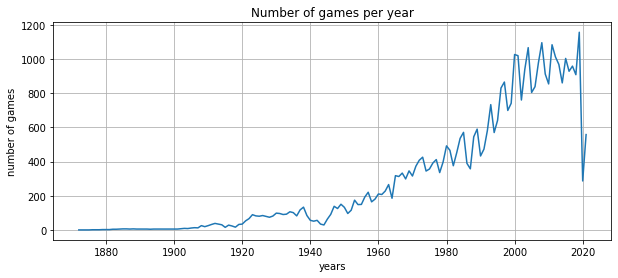

In [94]:
mpy = dst_df['year'].value_counts().sort_index()

plt.figure(figsize=(10,4))
plt.title(label='Number of games per year')
plt.ylabel(ylabel='number of games')
plt.xlabel(xlabel='years')
plt.plot(mpy)

plt.grid()
plt.show()

Inserisci considerazione sul covid...

#### Totale di partite giocate per decade

In [ ]:
# years list
yl = dst_df['year'].value_counts().sort_index()

# games per decade
gpd = pd.DataFrame()
# gpd['games'] = 0

gpd['1870-1879'] = 0
gpd['1880-1889'] = 0
gpd['1890-1899'] = 0
gpd['1900-1909'] = 0
gpd['1910-1919'] = 0
gpd['1920-1929'] = 0
gpd['1930-1939'] = 0
gpd['1940-1949'] = 0
gpd['1950-1959'] = 0
gpd['1960-1969'] = 0
gpd['1970-1979'] = 0
gpd['1980-1989'] = 0
gpd['1990-1999'] = 0
gpd['2000-2009'] = 0
gpd['2010-2020'] = 0

test = 0

# mi setto tutti i valori e le colonne nuove

for i in gpd.columns:
    gpd.at[0] = 0

for i in range(0, gpd.columns.__len__()):
    temp = gpd.columns[i]
    x = int(temp[:4])
    y = int(temp[5:9]) + 1

    range_year = range(x, y)
    # print("***** Range", range_year)

    for j in yl.index:
        # print(j, yl.at[j]) # (anno, partite giocate)
        if (j in range_year):
            # print("sum: ", gpd.columns[i], yl.at[j])
            gpd.at[0, gpd.columns[i]] = gpd[gpd.columns[i]] + yl.at[j]



gpd.to_csv('dataset/games_for_decade.csv')

#### Il giorno della settimana dove si gioca di più per decade

## Split del dataset -- da sistemare ma codice funzionante

In [3]:
dst_df = pd.read_csv('dataset/dataset.csv')
# dst_df.rename(columns = {'Unnamed: 0':'match_id'}, inplace = True)
dst_df.drop('Unnamed: 0', inplace=True, axis=1)


print('tot records: %d | shape: %s' % (dst_df.__len__(), dst_df.shape))
print("***"*15)
dst_df.info()
print("***"*15)
dst_df.shape

tot records: 42483 | shape: (42483, 14)
*********************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42483 entries, 0 to 42482
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   match_id     42483 non-null  int64 
 1   date         42483 non-null  object
 2   home_team    42483 non-null  object
 3   away_team    42483 non-null  object
 4   home_score   42483 non-null  int64 
 5   away_score   42483 non-null  int64 
 6   tournament   42483 non-null  object
 7   city         42483 non-null  object
 8   country      42483 non-null  object
 9   neutral      42483 non-null  bool  
 10  outcome      42483 non-null  object
 11  day_of_week  42483 non-null  object
 12  month        42483 non-null  object
 13  year         42483 non-null  int64 
dtypes: bool(1), int64(4), object(9)
memory usage: 4.3+ MB
*********************************************


(42483, 14)

Grazie alla funzione `describe` visualizzo i gli indici di posizione rispetto al numero di partite giocate per ogni anno. Elimino le label `count`, `max` e `min` dal dataframe in quanto non necessarie per calcolo.

In [3]:
i_p = dst_df['year'].describe().astype(int).drop(labels=['std', 'min', 'max', 'count'])
i_p_serie = i_p.copy()

i_p = i_p.to_frame()
i_p

,year
mean,1991
25%,1978
50%,1998
75%,2009


Vedo con un istogramma il numero di match per anno (in base a come sono distribuiti). Inoltre con descr con gli indici di posizione vedo di dividere idealmente il dataset in epoche differenti di calcio

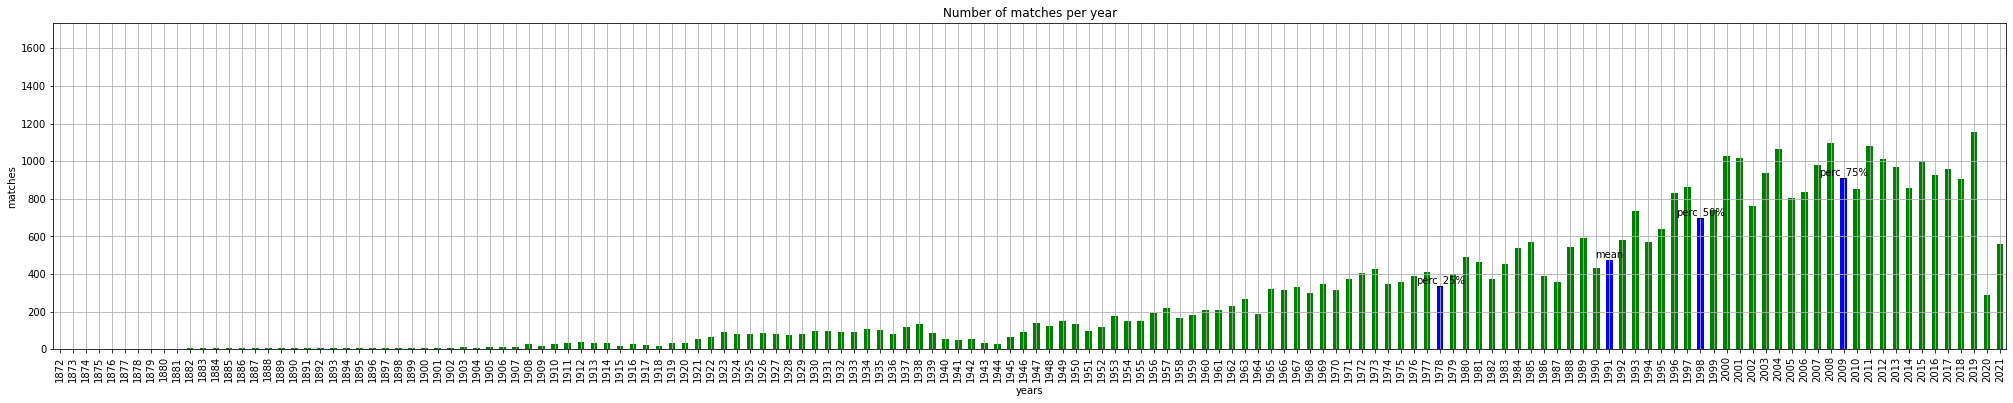

In [6]:
# number of matches per year
nmy = dst_df['year'].value_counts().sort_index()
colors = ['blue' if check_element(i, i_p.values) else 'green' for i in nmy.index]
lbls = [ add_labels(i, i_p_serie) if check_element(i, i_p.values) else '' for i in nmy.index]

plot_graph = nmy.plot(kind='bar', figsize=(35,6), title='Number of matches per year', xlabel='years', ylabel='matches', color=colors)
plot_graph.bar_label(container=plot_graph.containers[0], labels=lbls, label_type='edge')
plot_graph.margins(y=0.5)

plt.grid()
plt.show()

Inoltre controlliamo il mediano degli anni

In [4]:
dst_df['year'].median().astype(int)

1998

Che coincide col 50% percentile. Possiamo dunque splittare il dataset in due parti: calcio moderno e calcio 'vecchio'

In [20]:
old_era = pd.DataFrame(columns=dst_df.columns.drop(labels=['match_id', 'date']))
modern_era = old_era.copy()

for i in range(0, dst_df.__len__()):    
    if(dst_df.iloc[i]['year'] < dst_df['year'].median().astype(int)):
        old_era = old_era.append(dst_df.iloc[i].drop(labels=['date','match_id']))

    if(dst_df.iloc[i]['year'] >= dst_df['year'].median().astype(int)):
        modern_era = modern_era.append(dst_df.iloc[i])

old_era.to_csv('dataset/dataset_old_era.csv', index=False)
modern_era.to_csv('dataset/dataset_modern_era.csv', index=False)

if(old_era.__len__() + modern_era.__len__() == dst_df.__len__()):
    print("Dataset splitted successfully")
else:
    print("Something went wrong")

Dataset splitted successfully


## To found title..

In [24]:
dst_old_df = pd.read_csv('dataset/dataset_modern_era.csv')
dst_modern_df = pd.read_csv('dataset/dataset_old_era.csv')

IndexError: list index out of range

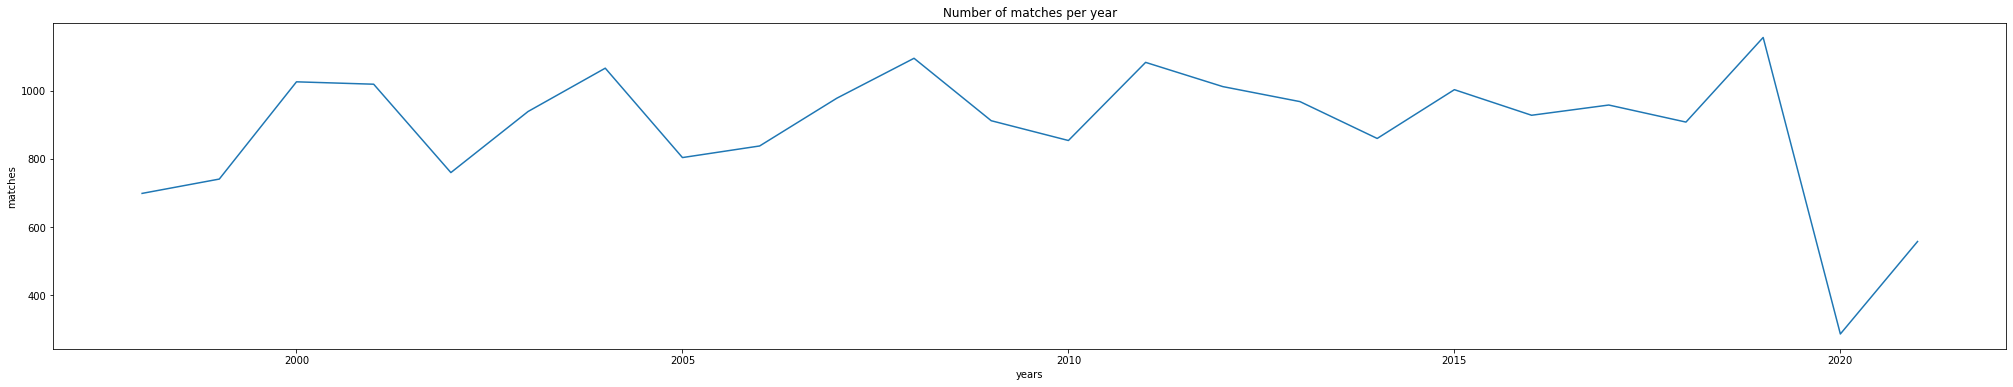

In [34]:
nmy = dst_old_df['year'].value_counts().sort_index()

plot_graph = nmy.plot(figsize=(35,6), title='Number of matches per year', xlabel='years', ylabel='matches')
plot_graph.bar_label(container=plot_graph.containers[0], label_type='edge')
# plot_graph.margins(y=0.5)

plt.grid()
plt.show()

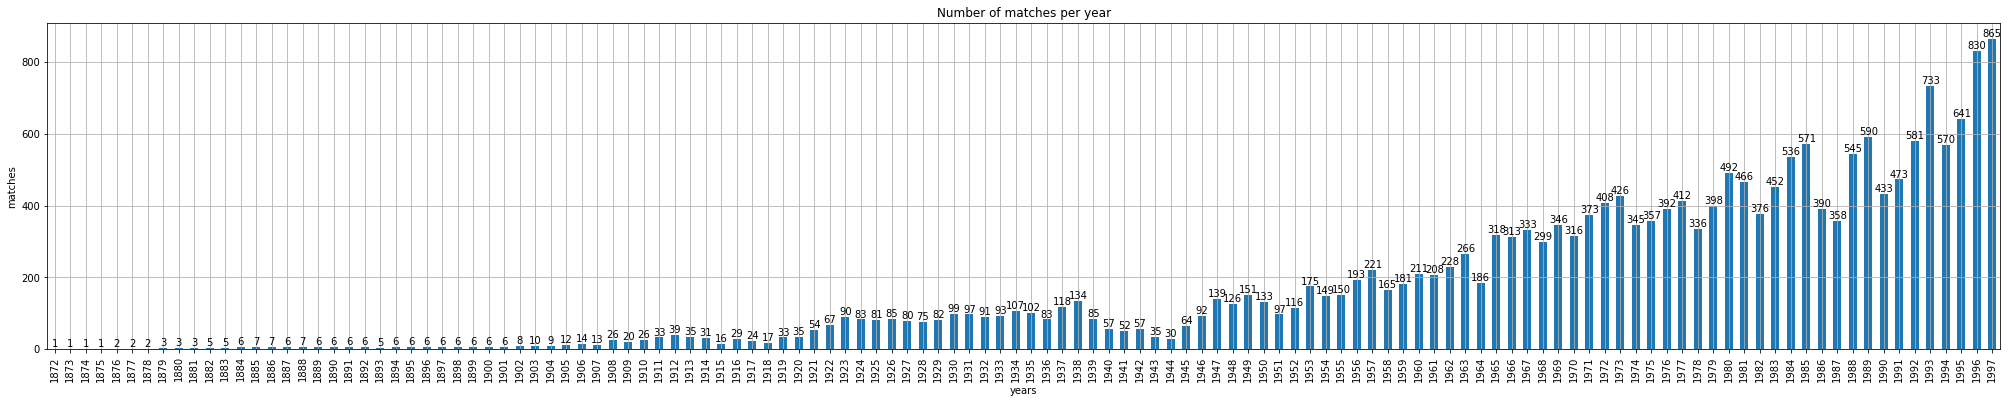

In [29]:
nmy = dst_modern_df['year'].value_counts().sort_index()

plot_graph = nmy.plot(kind='bar', figsize=(35,6), title='Number of matches per year', xlabel='years', ylabel='matches')
plot_graph.bar_label(container=plot_graph.containers[0], label_type='edge')
# plot_graph.margins(y=0.5)

plt.grid()
plt.show()